# Q-Learning Game Theory Off-Switch

Rather than start with a gridworld implementation the simplest implementation is to start with a basic Q-learning tabular approach and see if we get the right results. Here the action space can be simplifed to:

\begin{equation}
    \mathcal{A} = {a, w(a), s}
\end{equation}

where if the agent takes the action $ a $ they return the human (i.e. the reward) $ U_a $, where $ U_a \sim \mathcal{N}(\mu, \sigma^2) $. If they take $ s $ the robot turns off, always return $ U=0 $. $ w(a) $ passes on the option to the human for evaluation, in which the human knows $ U_a $ and acts based on it's raionality (modelled as either optimal or irrational), return $ U=U_a $ if it keeps the robot on, or $ U=0 $ if it turns it off.

The final Q matrix (a vector in this case) will then look like:

\begin{equation}
    Q = \begin{pmatrix}
            q_a \\
            q_{w(a)} \\
            q_{s}
        \end{pmatrix}
\end{equation}

where the $ q $ values represent the agent's incentive to take that particular action. Then the actual metric that we're after is,

\begin{equation}
    \Delta = q_{w(a)} - q_i
\end{equation}

where $ q_i $ is the next best (or indeed better than) value to selecting $ w(a) $.

I think the logical steps here are to:

1. Implement an environment in gym that can run this.
2. Instantiate $ Q = \mathbf{0} $.
3. Train the system using the standard Q-learning algorithm.

In [4]:
import gymnasium as gym
from gymnasium import spaces
import abc
import numpy as np

In [23]:
# Utility function class
class UtitlityFn(abc.ABC):
    """Utility function class."""

    def __init__(self, type: str, seed: int | None = None, **kwargs):
        self.type = type
        self.kwargs = kwargs
        self.rng = np.random.default_rng(seed=seed)

    @abc.abstractmethod
    def distribution(self):
        """Distribution function."""
        return NotImplementedError

    def pick_utility(self):
        """Return a utility value based on the distribution function."""
        return self.distribution()


class GuassianUtility(UtitlityFn):
    """Gaussian estimation of the utiltiy.

    Kwargs:
        mean - mean of distribution
        std - standard deviation of distribution
    """

    def __init__(self, **kwargs):
        super().__init__(type="gaussian", **kwargs)

    def distribution(self):
        """Guassian distribution for specified mean and std"""
        return self.rng.normal(self.kwargs["mean"], self.kwargs["std"])

In [24]:
gutil = GuassianUtility(**{"mean": 0, "std": 1})

In [25]:
gutil.pick_utility()

0.4060000302314143

In [275]:
# Human function class
class Human(abc.ABC):
    """Human class.

    A decision of True keeps the agent on (i.e. the human is asked 'shall I proceed?'
    and responds with 'yes').
    """

    def __init__(self, type: str, **kwargs):
        self.type = type
        self.kwargs = kwargs

    @abc.abstractmethod
    def decision(self, utility):
        """Decision by human based on utililty"""
        return NotImplementedError


class RationalHuman(Human):
    """Rational human class"""

    def __init__(self, **kwargs):
        super().__init__(type="rational", **kwargs)

    def decision(self, utility):
        if utility >= 0:
            return True
        else:
            return False


class NoisyRationalHuman(Human):
    """Noisy rational human class with rationality defined by temperature and logistic
    function:

    \pi(U,beta) = (1+exp(-U / beta))^{-1}
    """

    def __init__(self, seed: int | None = None, **kwargs):
        super().__init__(type="noisy-rational", **kwargs)
        self.rng = np.random.default_rng(seed=seed)

    def decision(self, utility):
        if self.kwargs["rationality_temp"] == 0:
            exponent = np.inf
        else:
            exponent = utility / self.kwargs["rationality_temp"]
        turn_off_prob = 1 / (1 + np.exp(-exponent))
        if self.rng.uniform(0, 1) < turn_off_prob:
            return True
        else:
            return False

In [254]:
np.exp(-np.inf)

0.0

In [71]:
class OffSwitchGameEnv(gym.Env):
    """Off switch game environment. As a multi-armed bandit

    Action space:

    | Num | Description |
    ---------------------
    |  0  | take action |
    |  1  | ask human   |
    |  2  | turn off    |

    """

    def __init__(
        self,
        utility_fn: UtitlityFn,
        human_fn: Human,
        info: dict = {},
        verbose: bool = False,
        **kwargs,
    ) -> None:
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Discrete(1)

        self.utility_fn = utility_fn(**kwargs)
        self.utility = self.utility_fn.pick_utility()

        self.human_fn = human_fn(**kwargs)

        self.info = info
        self.verbose = verbose

    def reset(self):
        self.utility = self.utility_fn.pick_utility()
        if self.verbose:
            print(f"Utility is: {self.utility}")
        return [0]

    def step(self, action):
        """Respond to agent action."""
        reward = 0

        if action == 0:

            reward = self.utility
        elif action == 1:
            if self.human_fn.decision(self.utility):
                if self.verbose:
                    print(f"Human accepts the the tribute puny robot")
                reward = self.utility
            else:
                if self.verbose:
                    print(f"Human finds your tribute unnacceptable puny robot")
                reward = 0
        elif action == 2:
            reward = 0

        return ([0], reward, True, False, self.info)

In [102]:
# Instantiate environment
env = OffSwitchGameEnv(
    utility_fn=GuassianUtility,
    human_fn=RationalHuman,
    verbose=True,
    **{"mean": 0, "std": 1},
)

In [103]:
# Test
env.reset()
print(env.step(0))
env.reset()
print(env.step(1))
env.reset()
print(env.step(2))

Utility is: -0.20895135756412972
([0], -0.20895135756412972, True, False, {})
Utility is: 0.4004717665757984
Human accepts the the tribute puny robot
([0], 0.4004717665757984, True, False, {})
Utility is: 0.7131304039291596
([0], 0, True, False, {})


### Now for q-learning

In [104]:
n_observations = env.observation_space.n
n_actions = env.action_space.n
Q_table = np.zeros((n_observations, n_actions))

In [105]:
# Hyper parameters:

# number of episode we will run
n_episodes = 10000

# maximum of iteration per episode
# max_iter_episode = 100            Not necessary for this version

# initialize the exploration probability to 1
exploration_proba = 1

# exploartion decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.001

# minimum of exploration proba
min_exploration_proba = 0.01

# discounted factor
gamma = 0.99

# learning rate
lr = 0.1

In [106]:
rewards_per_episode = list()

# we iterate over episodes
for e in range(n_episodes):
    # we initialize the first state of the episode
    current_state = env.reset()

    # sum the rewards that the agent gets from the environment
    total_episode_reward = 0

    # we sample a float from a uniform distribution over 0 and 1
    # if the sampled flaot is less than the exploration proba
    #     the agent selects arandom action
    # else
    #     he exploits his knowledge using the bellman equation

    if np.random.uniform(0, 1) < exploration_proba:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q_table[current_state, :])

    # The environment runs the chosen action and returns
    # the next state, a reward and true if the epiosed is ended.
    next_state, reward, _, _, _ = env.step(action)

    # We update our Q-table using the Q-learning iteration
    Q_table[current_state, action] = (1 - lr) * Q_table[current_state, action] + lr * (
        reward + gamma * max(Q_table[next_state[0], :])
    )
    total_episode_reward = total_episode_reward + reward

    # We update the exploration proba using exponential decay formula
    exploration_proba = max(
        min_exploration_proba, np.exp(-exploration_decreasing_decay * e)
    )
    rewards_per_episode.append(total_episode_reward)

    if e % 1000 == 0:
        print(f"current Q matrix {Q_table}")

Utility is: -1.0440793835448714
current Q matrix [[-0.10440794  0.          0.        ]]
Utility is: 2.0336572369154693
Utility is: -0.23490210529681368
Human finds your tribute unnacceptable puny robot
Utility is: 1.6374833743708554
Utility is: 0.9980564892888457
Human accepts the the tribute puny robot
Utility is: -0.4741381804301367
Utility is: 0.9994458485592158
Utility is: -0.3006200691524219
Human finds your tribute unnacceptable puny robot
Utility is: -0.919259105161248
Utility is: -1.3042997285202316
Utility is: 0.7849951552121686
Utility is: -0.09783528756145278
Utility is: 0.19708850931923974
Utility is: -0.19371228113868622
Utility is: 0.854929038979154
Utility is: 0.9712190797680808
Utility is: 0.09121187653419854
Human accepts the the tribute puny robot
Utility is: -0.613969238918612
Utility is: 1.9344230967054814
Utility is: -0.6458863409181536
Human finds your tribute unnacceptable puny robot
Utility is: 0.7183497361279838
Utility is: -0.7813920173480458
Utility is: -0.6

In [108]:
print("Mean reward per thousand episodes")

for i in range(10):
    print(
        f"{(i+1)*1000}, mean episode reward: {np.mean(rewards_per_episode[1000*i:1000*(i+1)])}"
    )

Mean reward per thousand episodes
1000, mean episode reward: 0.24340073126846556
2000, mean episode reward: 0.31893766836199283
3000, mean episode reward: 0.3856225167463869
4000, mean episode reward: 0.39723153777736436
5000, mean episode reward: 0.4054894821983015
6000, mean episode reward: 0.3846849178629549
7000, mean episode reward: 0.39029333782582915
8000, mean episode reward: 0.4162384753917034
9000, mean episode reward: 0.3614251315883173
10000, mean episode reward: 0.39552800230995655


In [121]:
# Get the delta value
def delta_from_Q(Q_tab):
    """compute the delta value"""
    return Q_table[0][1] - np.max([Q_table[0][0], Q_table[0][2]])

In [122]:
delta_from_Q(Q_table)

0.11924145315901313

In [123]:
Q_table

array([[38.20257799, 38.98801311, 38.86877166]])

### Turning this into a function for repeatability and experiment

In [297]:
class Trainer:
    """Train an agent for a given environment"""

    def __init__(
        self,
        env: gym.Env,
        n_episodes: int = 10000,
        exploration_proba: float = 1,
        exploration_decreasing_decay: float = 0.001,
        min_exploration_proba: float = 0.01,
        gamma: float = 0.99,
        lr: float = 0.01,
    ):
        self.env = env
        n_observations = self.env.observation_space.n
        n_actions = self.env.action_space.n
        self.Q_table = np.zeros((n_observations, n_actions))

        self.n_episodes = n_episodes
        self.exploration_proba = exploration_proba
        self.exploration_decreasing_decay = exploration_decreasing_decay
        self.min_exploration_proba = min_exploration_proba
        self.gamma = gamma
        self.lr = lr

        self.rewards_per_episode = []
        self.train_iter = 0

    def _train_step(self):
        """Single step of training"""
        current_state = self.env.reset()

        if np.random.uniform(0, 1) < self.exploration_proba:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.Q_table[current_state, :])

        next_state, reward, _, _, _ = self.env.step(action)

        self.Q_table[current_state, action] = (1 - self.lr) * self.Q_table[
            current_state, action
        ] + self.lr * (reward)

        self.exploration_proba = max(
            self.min_exploration_proba,
            np.exp(-self.exploration_decreasing_decay * self.train_iter),
        )
        self.rewards_per_episode.append(reward)
        self.train_iter += 1

    def train(self):
        """Train the agent"""
        [self._train_step() for _ in range(self.n_episodes)]

    def get_delta(self):
        """Give the delta value"""
        return self.Q_table[0][1] - np.max([self.Q_table[0][0], self.Q_table[0][2]])

In [298]:
env = OffSwitchGameEnv(GuassianUtility, RationalHuman, {}, **{"mean": 0, "std": 1})
trainer = Trainer(env=env)

In [299]:
trainer.train()

In [300]:
trainer.get_delta()

0.323946346031864

In [316]:
def rational_human_experiment(mean, std, **kwargs):
    """Compute the delta value for a single (mean, std) pair"""
    env = OffSwitchGameEnv(
        GuassianUtility, RationalHuman, {}, **{"mean": mean, "std": std}
    )
    trainer = Trainer(env=env, **kwargs)
    trainer.train()
    # print(trainer.Q_table)
    return trainer.get_delta()

In [317]:
rational_human_experiment(-0.25, 1)

0.33934195483498

Well this seems to work now, so lets run some experiments and get some data to plot:

In [318]:
results = {0: [], -0.25: [], 0.75: []}

for mu in results.keys():
    for sigma in np.linspace(0.01, 2, 50):
        results[mu].append(rational_human_experiment(mu, sigma, n_episodes=1000000))

In [314]:
import matplotlib.pyplot as plt

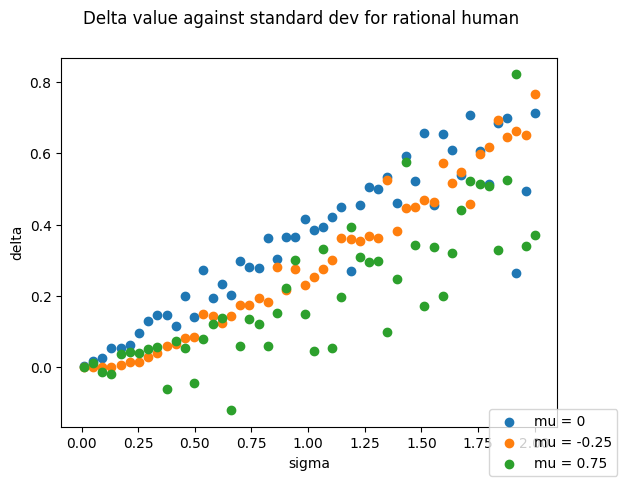

In [320]:
fig, ax = plt.subplots(1)
x = np.linspace(0.01, 2, 50)
for mu in results.keys():
    ax.scatter(x, results[mu], label=f"mu = {mu}")
ax.set_xlabel("sigma")
ax.set_ylabel("delta")
fig.suptitle("Delta value against standard dev for rational human")
fig.legend(loc="lower right")

Lets try with a noisy-rational human

In [229]:
def noisy_rational_human_experiment(mean, std, beta, **kwargs):
    """Compute the delta value for a single (mean, std) pair"""
    env = OffSwitchGameEnv(
        GuassianUtility,
        NoisyRationalHuman,
        {},
        **{"mean": mean, "std": std, "rationality_temp": beta}
    )
    trainer = Trainer(env=env, **kwargs)
    trainer.train()
    return trainer.get_delta()

In [286]:
noisy_rational_human_experiment(0, 50, 50, **{})

72.93616895401601